Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.2083, Accuracy: 15.39%, Validation: Loss: 1.9776, Accuracy: 24.74%
Epoch [2/70] Training: Loss: 1.8137, Accuracy: 31.41%, Validation: Loss: 1.6693, Accuracy: 37.11%
Epoch [3/70] Training: Loss: 1.5647, Accuracy: 41.23%, Validation: Loss: 1.4848, Accuracy: 43.97%
Epoch [4/70] Training: Loss: 1.3940, Accuracy: 48.59%, Validation: Loss: 1.3208, Accuracy: 50.43%
Epoch [5/70] Training: Loss: 1.2311, Accuracy: 54.95%, Validation: Loss: 1.1914, Accuracy: 56.70%
Epoch [6/70] Training: Loss: 1.0945, Accuracy: 60.47%, Validation: Loss: 1.0531, Accuracy: 61.86%
Epoch [7/70] Training: Loss: 0.9961, Accuracy: 64.54%, Validation: Loss: 0.9575, Accuracy: 66.30%
Epoch [8/70] Training: Loss: 0.8994, Accuracy: 68.07%, Validation: Loss: 0.8377, Accuracy: 70.80%
Epoch [9/70] Training: Loss: 0.8270, Accuracy: 70.55%, Validation: Loss: 0.8216, Accuracy: 71.33%
Epoch [10/70] Training: Loss: 0.7667, Accu

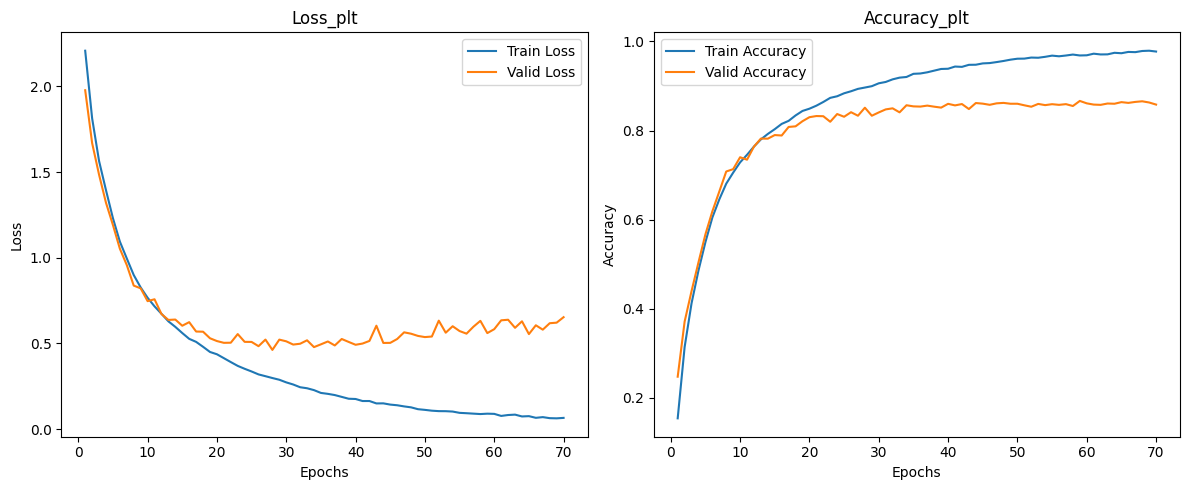

In [5]:
# AlexNet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
#  AlexNet 模型
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),  # Alex采用的新型的relu激活函数
            nn.MaxPool2d(kernel_size=2, stride=2),  # 最大池化
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # Alex采用了Dropout
            nn.Linear(256 * 4 * 4, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  
        x = self.classifier(x)
        return x

# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
train(epochs)
test()

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.4547, Accuracy: 45.89%, Validation: Loss: 1.4340, Accuracy: 53.23%
Epoch [2/70] Training: Loss: 1.0284, Accuracy: 63.19%, Validation: Loss: 1.1293, Accuracy: 60.08%
Epoch [3/70] Training: Loss: 0.8454, Accuracy: 70.14%, Validation: Loss: 0.8575, Accuracy: 69.78%
Epoch [4/70] Training: Loss: 0.7094, Accuracy: 75.33%, Validation: Loss: 0.8368, Accuracy: 70.50%
Epoch [5/70] Training: Loss: 0.6392, Accuracy: 77.95%, Validation: Loss: 0.6708, Accuracy: 76.85%
Epoch [6/70] Training: Loss: 0.5753, Accuracy: 80.08%, Validation: Loss: 0.6421, Accuracy: 77.76%
Epoch [7/70] Training: Loss: 0.5276, Accuracy: 81.77%, Validation: Loss: 0.5784, Accuracy: 79.97%
Epoch [8/70] Training: Loss: 0.4830, Accuracy: 83.33%, Validation: Loss: 0.5879, Accuracy: 79.80%
Epoch [9/70] Training: Loss: 0.4533, Accuracy: 84.21%, Validation: Loss: 0.5593, Accuracy: 81.14%
Epoch [10/70] Training: Loss: 0.4255, Accu

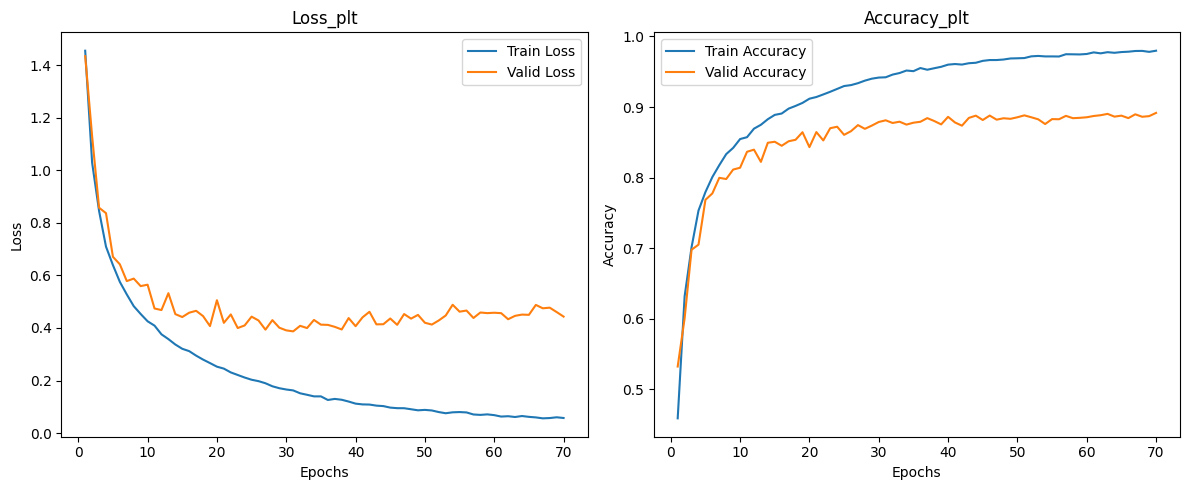

In [1]:
# bn残差网络
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time


# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(32, 64, stride=2)
        self.layer2 = self.make_layer(64, 128, stride=2)
        self.layer3 = self.make_layer(128, 128, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride, downsample),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 计时开始
all_start = time.time()

# 执行训练和评估
train(epochs)
test()

all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()




Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.8249, Accuracy: 38.70%, Validation: Loss: 1.5505, Accuracy: 50.25%
Epoch [2/70] Training: Loss: 1.2023, Accuracy: 58.90%, Validation: Loss: 1.1550, Accuracy: 60.23%
Epoch [3/70] Training: Loss: 0.9408, Accuracy: 67.98%, Validation: Loss: 0.8553, Accuracy: 70.26%
Epoch [4/70] Training: Loss: 0.7440, Accuracy: 74.33%, Validation: Loss: 1.0641, Accuracy: 65.73%
Epoch [5/70] Training: Loss: 0.6292, Accuracy: 78.14%, Validation: Loss: 0.7086, Accuracy: 75.37%
Epoch [6/70] Training: Loss: 0.5574, Accuracy: 80.67%, Validation: Loss: 0.6566, Accuracy: 78.00%
Epoch [7/70] Training: Loss: 0.5038, Accuracy: 82.78%, Validation: Loss: 0.6247, Accuracy: 79.10%
Epoch [8/70] Training: Loss: 0.4589, Accuracy: 84.23%, Validation: Loss: 0.6690, Accuracy: 77.90%
Epoch [9/70] Training: Loss: 0.4136, Accuracy: 85.59%, Validation: Loss: 0.5409, Accuracy: 82.42%
Epoch [10/70] Training: Loss: 0.3866, Accu

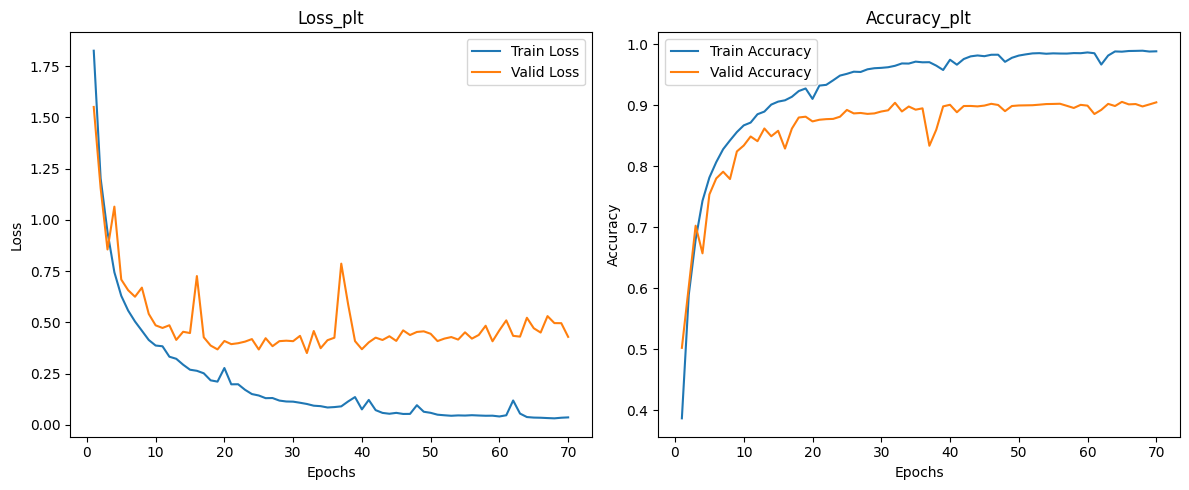

In [2]:
# 带dropout0.4的残差网络+lenet中# dropout 0.3 +resnet + 数据增强
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time


# # 定义残差块
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.downsample = downsample
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         identity = x
#         if self.downsample is not None:
#             identity = self.downsample(x)
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += identity
#         out = self.relu(out)
#         return out

# # 定义 ResNet 模型
# class ResNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet, self).__init__()
#         self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(32)
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self.make_layer(32, 64, stride=2)
#         self.layer2 = self.make_layer(64, 128, stride=2)
#         self.layer3 = self.make_layer(128, 128, stride=2)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128, num_classes)

#     def make_layer(self, in_channels, out_channels, stride):
#         downsample = None
#         if stride != 1 or in_channels != out_channels:
#             downsample = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )
#         return nn.Sequential(
#             ResidualBlock(in_channels, out_channels, stride, downsample),
#             ResidualBlock(out_channels, out_channels)
#         )

#     def forward(self, x):
#         x = self.relu(self.bn(self.conv(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.avg_pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

class Block(nn.Module):
    def __init__(self, inchannel, outchannel, res=True, stride=1):
        super(Block, self).__init__()
        self.res = res     # 是否带残差连接
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(outchannel),
        )
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, bias=False),
                nn.BatchNorm2d(outchannel),
            )
        else:
            self.shortcut = nn.Sequential()
 
        self.relu = nn.Sequential(
            nn.ReLU(inplace=True),
        )
 
    def forward(self, x):
        out = self.left(x)
        if self.res:
            out += self.shortcut(x)
        out = self.relu(out)
        return out
 
 
class ResNet(nn.Module):
    def __init__(self, cfg=[64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512,'M'], res=True):
        super(ResNet, self).__init__()
        self.res = res       # 是否带残差连接
        self.cfg = cfg       # 配置列表
        self.inchannel = 3   # 初始输入通道数
        self.futures = self.make_layer()
        # 构建卷积层之后的全连接层以及分类器：
        self.classifier = nn.Sequential(nn.Dropout(0.4),           # 两层fc效果还差一些
                                        nn.Linear(4 * 512, 10), )   # fc，最终Cifar10输出是10类
 
    def make_layer(self):
        layers = []
        for v in self.cfg:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(Block(self.inchannel, v, self.res))
                self.inchannel = v    # 输入通道数改为上一层的输出通道数
        return nn.Sequential(*layers)
 
    def forward(self, x):
        out = self.futures(x)
        # view(out.size(0), -1): change tensor size from (N ,H , W) to (N, H*W)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 计时开始
all_start = time.time()

# 执行训练和评估
train(epochs)
test()

all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()




Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.1010, Accuracy: 19.67%, Validation: Loss: 1.9639, Accuracy: 20.59%
Epoch [2/70] Training: Loss: 1.7943, Accuracy: 29.52%, Validation: Loss: 1.6457, Accuracy: 35.73%
Epoch [3/70] Training: Loss: 1.5947, Accuracy: 38.71%, Validation: Loss: 1.5756, Accuracy: 38.93%
Epoch [4/70] Training: Loss: 1.4109, Accuracy: 46.68%, Validation: Loss: 1.3153, Accuracy: 49.99%
Epoch [5/70] Training: Loss: 1.2568, Accuracy: 53.39%, Validation: Loss: 1.1536, Accuracy: 57.63%
Epoch [6/70] Training: Loss: 1.1193, Accuracy: 59.21%, Validation: Loss: 1.0882, Accuracy: 61.08%
Epoch [7/70] Training: Loss: 1.0240, Accuracy: 62.97%, Validation: Loss: 0.9483, Accuracy: 65.91%
Epoch [8/70] Training: Loss: 0.9352, Accuracy: 66.39%, Validation: Loss: 1.0246, Accuracy: 63.34%
Epoch [9/70] Training: Loss: 0.8738, Accuracy: 68.55%, Validation: Loss: 0.8670, Accuracy: 69.11%
Epoch [10/70] Training: Loss: 0.8034, Accu

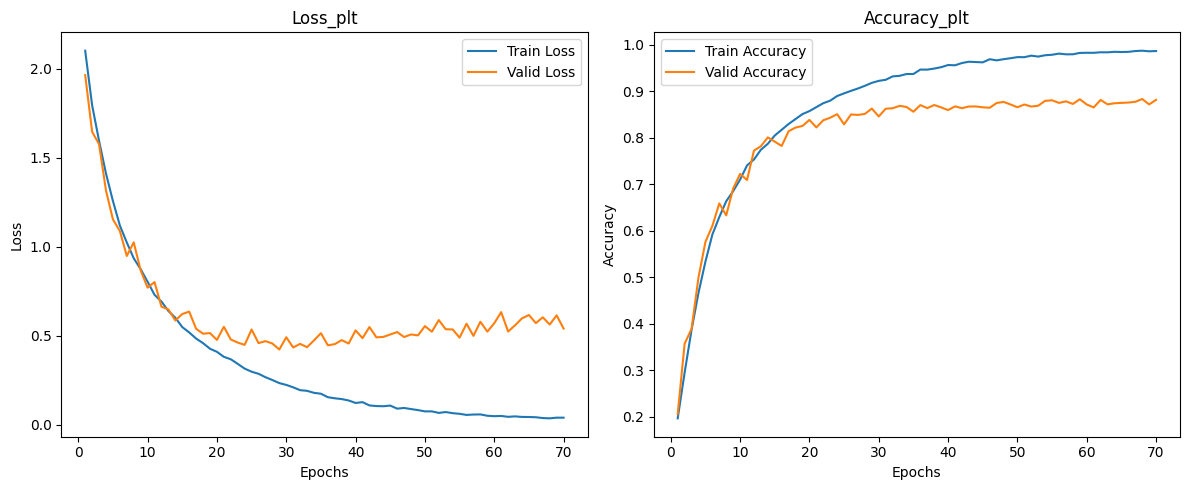

In [7]:
# 基于Alex改造的resnet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return self.relu(out + self.shortcut(x))  # 残差连接

# 带有残差连接的 AlexNet 模型
class AlexNetWithResiduals(nn.Module):
    def __init__(self):
        super(AlexNetWithResiduals, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化,用于通道降维
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 , 64),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  
        x = self.classifier(x)
        return x
    
# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetWithResiduals().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.0418, Accuracy: 23.68%, Validation: Loss: 1.7469, Accuracy: 35.08%
Epoch [2/70] Training: Loss: 1.5978, Accuracy: 40.52%, Validation: Loss: 1.4305, Accuracy: 46.93%
Epoch [3/70] Training: Loss: 1.3549, Accuracy: 50.44%, Validation: Loss: 1.2650, Accuracy: 54.24%
Epoch [4/70] Training: Loss: 1.1896, Accuracy: 57.12%, Validation: Loss: 1.0976, Accuracy: 59.88%
Epoch [5/70] Training: Loss: 1.0388, Accuracy: 62.87%, Validation: Loss: 0.9742, Accuracy: 65.03%
Epoch [6/70] Training: Loss: 0.9353, Accuracy: 66.64%, Validation: Loss: 0.9138, Accuracy: 67.57%
Epoch [7/70] Training: Loss: 0.8552, Accuracy: 69.66%, Validation: Loss: 0.8706, Accuracy: 69.54%
Epoch [8/70] Training: Loss: 0.7893, Accuracy: 71.95%, Validation: Loss: 0.7582, Accuracy: 73.80%
Epoch [9/70] Training: Loss: 0.7110, Accuracy: 74.92%, Validation: Loss: 0.6684, Accuracy: 76.38%
Epoch [10/70] Training: Loss: 0.6592, Accu

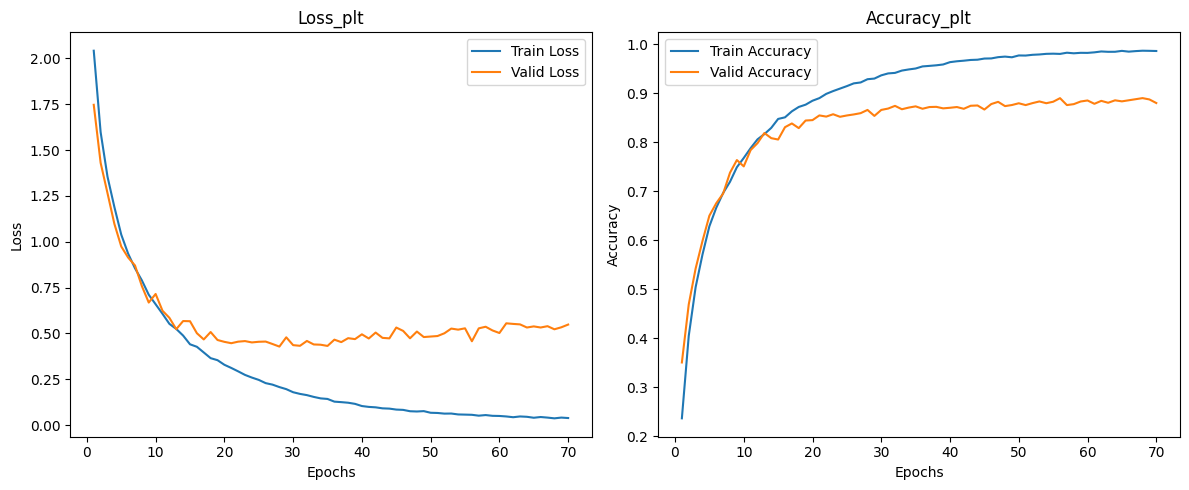

In [2]:
# 基于Alex改造的resnet + dropout 使用随机丢弃
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return self.relu(out + self.shortcut(x))  # 残差连接

# 带有残差连接的 AlexNet 模型
class AlexNetWithResiduals(nn.Module):
    def __init__(self):
        super(AlexNetWithResiduals, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  # 添加 dropout 层，丢弃率为 50%
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # 添加 dropout 层，丢弃率为 50%
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
    
# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetWithResiduals().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.1682, Accuracy: 20.01%, Validation: Loss: 1.6968, Accuracy: 35.35%
Epoch [2/70] Training: Loss: 1.5501, Accuracy: 42.34%, Validation: Loss: 1.3535, Accuracy: 49.40%
Epoch [3/70] Training: Loss: 1.2243, Accuracy: 56.13%, Validation: Loss: 1.0599, Accuracy: 61.62%
Epoch [4/70] Training: Loss: 0.9996, Accuracy: 64.66%, Validation: Loss: 1.0783, Accuracy: 63.29%
Epoch [5/70] Training: Loss: 0.8457, Accuracy: 70.44%, Validation: Loss: 0.9004, Accuracy: 69.27%
Epoch [6/70] Training: Loss: 0.7405, Accuracy: 74.77%, Validation: Loss: 0.7839, Accuracy: 72.87%
Epoch [7/70] Training: Loss: 0.6541, Accuracy: 78.09%, Validation: Loss: 0.5975, Accuracy: 79.86%
Epoch [8/70] Training: Loss: 0.5920, Accuracy: 80.33%, Validation: Loss: 0.5411, Accuracy: 81.88%
Epoch [9/70] Training: Loss: 0.5305, Accuracy: 82.44%, Validation: Loss: 0.6005, Accuracy: 80.33%
Epoch [10/70] Training: Loss: 0.4877, Accu

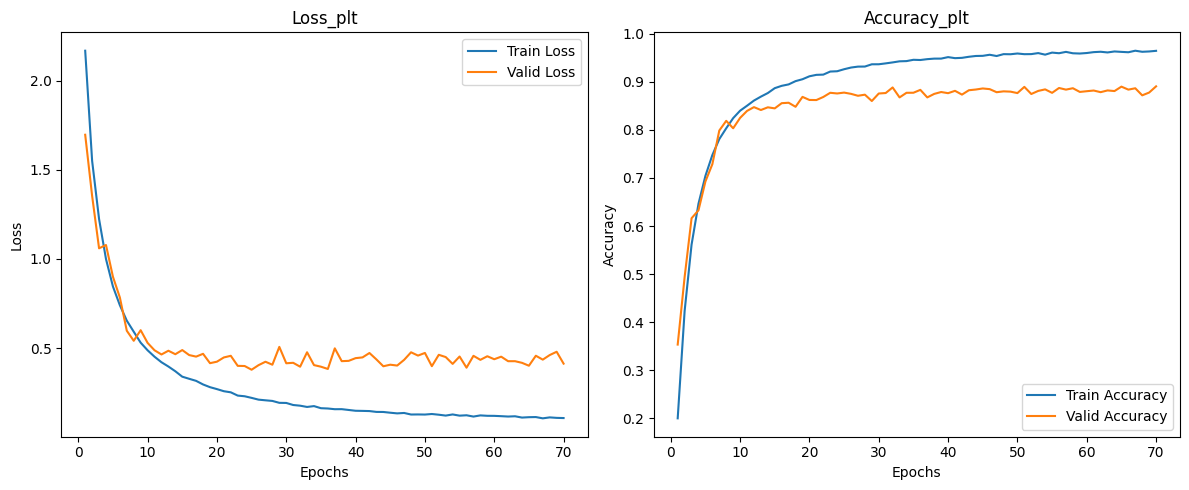

In [3]:
# 基于Alex改造的resnet + dropout! + bn + weight decay(Adam) + 减轻全连接
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRR(nn.Module):
    def __init__(self):
        super(RRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化，输出为 (256, 1, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()